In [1]:
import tkinter as tk
from tkinter import filedialog
from tkinter import ttk
import cv2
import numpy as np
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
from PIL import Image, ImageTk
import warnings

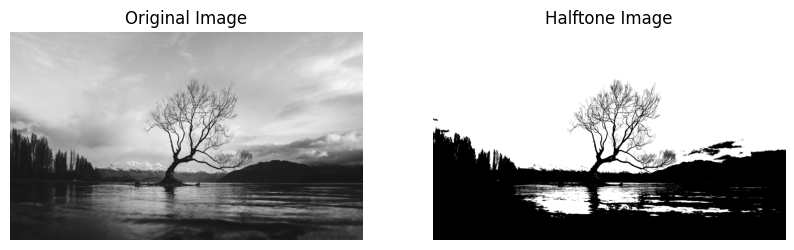

In [2]:
def halftone_threshold(image, threshold=128):
    # Convert the image to grayscale if it is in color
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image
    
    # Initialize the halftone image 
    halftone_image = gray_image.copy()

    for i in range(gray_image.shape[0]):  # Loop through each row
        for j in range(gray_image.shape[1]):  # Loop through each column
            if gray_image[i, j] >= threshold:
                halftone_image[i, j] = 255  # Set to white
            else:
                halftone_image[i, j] = 0  # Set to black
    return halftone_image
    
# Load an image
image = cv2.imread('image1.jpg', cv2.IMREAD_COLOR)

# Apply halftone algorithm
halftoned_image = halftone_threshold(image)

# Show the original and halftone images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(halftoned_image, cmap='gray')
plt.title("Halftone Image")
plt.axis('off')

plt.show()

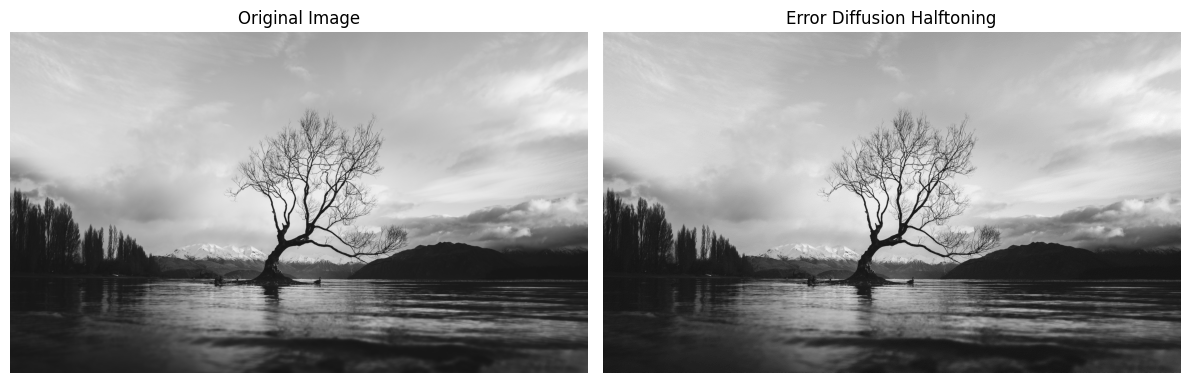

In [3]:
def error_diffusion_halftoning(image, threshold=128):
    # Convert image to grayscale if it isn't already
    if image.mode != 'L':
        image = image.convert('L')

    # Convert the image into a NumPy array
    img_array = np.array(image, dtype=np.float32)  # Use float to handle errors

    # Get dimensions of the image
    height, width = img_array.shape

    # Process each pixel in the image
    for i in range(height):
        for j in range(width):
            old_pixel = img_array[i, j]
            new_pixel = 255 if old_pixel >= threshold else 0  # Thresholding
            img_array[i, j] = new_pixel  # Update the pixel

            # Calculate the error
            error = old_pixel - new_pixel

            # Propagate the error to neighbors (Floyd-Steinberg)
            #factor determine how much of the error is passed to each neighboring pixel.
            if j + 1 < width:
                img_array[i, j + 1] += error * 7 / 16  #Right
            if i + 1 < height and j > 0:
                img_array[i + 1, j - 1] += error * 3 / 16  #Bottom-left 
            if i + 1 < height:
                img_array[i + 1, j] += error * 5 / 16  #Bottom
            if i + 1 < height and j + 1 < width:
                img_array[i + 1, j + 1] += error * 1 / 16 # Bottom-right

    img_array = np.clip(img_array, 0, 255)

    return Image.fromarray(img_array.astype(np.uint8))

image = Image.open('image1.jpg')

halftoned_image = error_diffusion_halftoning(image)

plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

# Halftoned image
plt.subplot(1, 2, 2)
plt.title("Error Diffusion Halftoning")
plt.imshow(halftoned_image, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

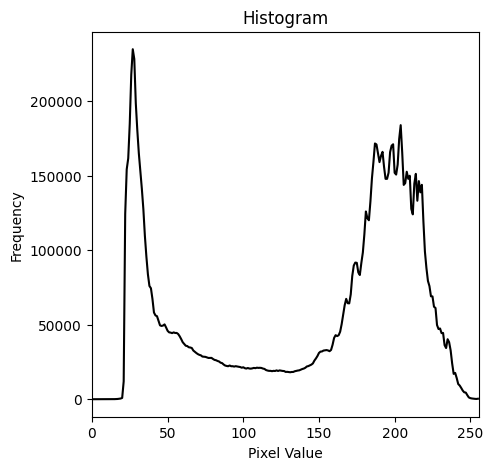

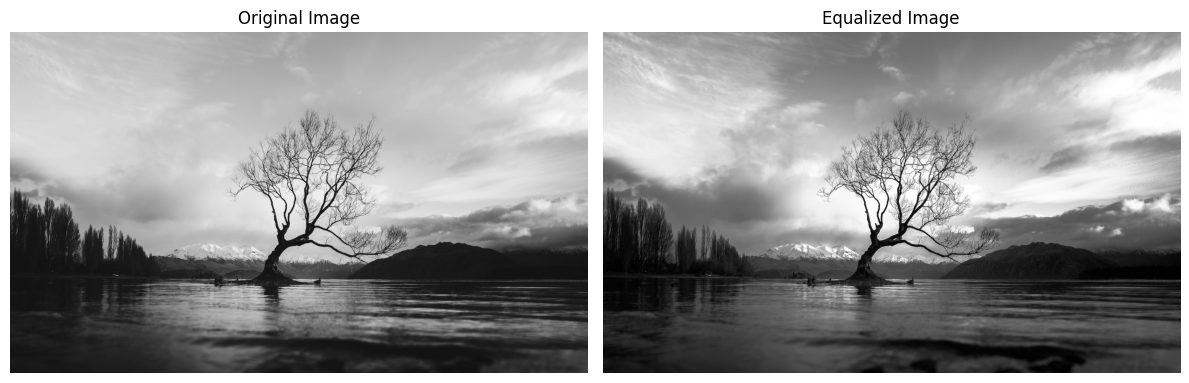

In [4]:
def calculate_histogram(image):
    #initializes an array of size 256
    hist = np.zeros(256, dtype=int)
    rows, cols = image.shape

    for i in range(rows):
        for j in range(cols):
            k = image[i][j]
            hist[k] += 1
    
    return hist


def cumulative_histogram(hist):
    sum_of_hist = np.zeros (256, dtype = int)
    sum = 0
    
    for i in range(256):
        sum += hist[i]
        sum_of_hist[i] = sum
    
    return sum_of_hist
    

def histogram_equalization(image):
    
    hist = calculate_histogram(image)
    
    sum_of_hist = cumulative_histogram(hist)

    rows, cols = image.shape
    area = rows * cols
    Dm = 255  # #of graylevels in the output

    #array is initialized as an empty image of the same shape as the input image.
    out_image = np.zeros_like(image)

    #transform input image to output image

    for i in range(rows):
        for j in range(cols):
            k = image[i][j]
            out_image[i][j] = (Dm / area) * sum_of_hist[k]
            out_image[i][j] = np.clip(out_image[i][j], 0 , Dm)
    
    return out_image.astype(np.uint8), hist , sum_of_hist


image = plt.imread('image1.jpg')
if image.ndim == 3:
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#The output image after histogram equalization (improved contrast)
#The original histogram of the input image.
equalized_image, histogram, sum_of_hist = histogram_equalization(image)

# Calculate histogram of equalized image optional
equalized_histogram = calculate_histogram(equalized_image)




# # Plot histograms
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.title('Original Histogram')
# plt.plot(histogram, color='black', label='Original Histogram')
# plt.xlabel('Pixel Value')
# plt.ylabel('Frequency')
# plt.xlim([0, 256])

# plt.subplot(1, 2, 2)
# plt.title('Equalized Histogram')
# plt.plot(equalized_histogram, color='red', label='Equalized Histogram')
# plt.xlabel('Pixel Value')
# plt.ylabel('Frequency')
# plt.xlim([0, 256])

# plt.tight_layout()
# plt.show()


plt.figure(figsize=(5,5))
plt.title('Histogram')
plt.plot(histogram, color='black', label='Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.xlim([0, 256])
plt.show

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(image,cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title('Equalized Image')
plt.imshow(equalized_image,cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()




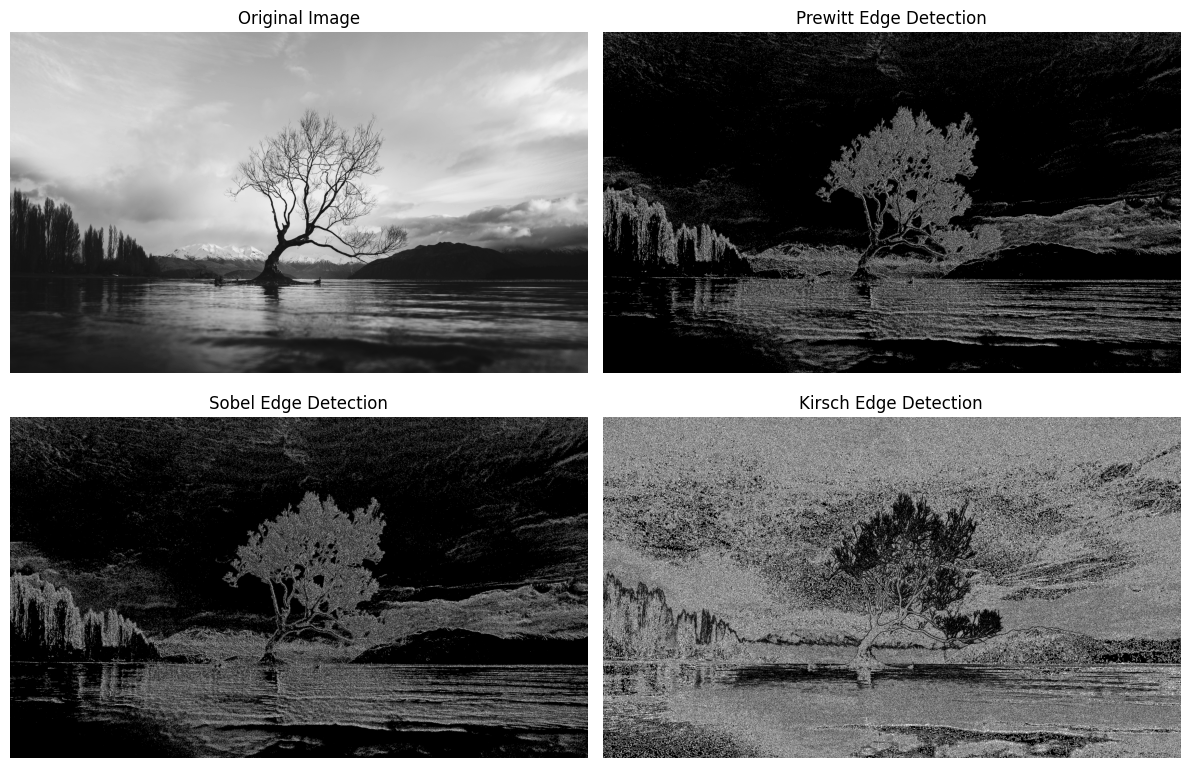

In [5]:
prewitt_masks = {

    'Gx': np.array([[-1, 0, 1],
                    [-1, 0, 1],
                    [-1, 0, 1]]),
    'Gy': np.array([[1, 1, 1],
                    [0, 0, 0],
                    [-1, -1, -1]])
}

sobel_masks = {
    'Gx': np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]]),
                    
    'Gy': np.array([[1, 2, 1],
                    [0, 0, 0],
                    [-1, -2, -1]]),
                    
}


kirsch_masks = [
    np.array([[-3, -3, 5],
              [-3, 0, 5],
              [-3, -3 ,5]]),

    np.array([[-3, 5, 5],
              [-3, 0, 5],
              [-3, -3 ,-3]]),

    np.array([[5, 5, 5],
              [-3, 0, -3],
              [-3, -3 ,-3]]),

    np.array([[5, 5, -3],
              [5, 0, -3],
              [-3, -3 ,-3]]),

    np.array([[5, -3, -3],
              [5, 0, -3],
              [5, -3 ,-3]]),

    np.array([[-3, -3, -3],
              [5, 0, -3],
              [5, 5 ,-3]]),

    np.array([[-3, -3, -3],
              [-3, 0, -3],
              [5, 5 ,5]]),

    np.array([[-3, -3, -3],
              [-3, 0, 5],
              [-3, 5 ,5]]),

]

#apply_convolution highlights specific features (edges)
#-1 indicates that the output image will have the same depth as the input image.
def apply_convolution(image, kernel):
    return cv2.filter2D(image, -1, kernel)

def detect_edges(image, method= 'prewitt', threshold=128):
    if method == 'prewitt':
        gx = apply_convolution(image, prewitt_masks['Gx'])
        gy = apply_convolution(image, prewitt_masks['Gy'])
    elif method == 'sobel':
        gx = apply_convolution(image, sobel_masks['Gx'])
        gy = apply_convolution(image, sobel_masks['Gy'])
    elif method == 'kirsch':
        responses = []
        for mask in kirsch_masks:
            response = apply_convolution(image, mask)
            responses.append(response)
            
        # Get the maximum response
        gx = np.max(responses, axis=0)
        gy = np.max(responses, axis=0)
    else:
        raise ValueError("Unknown method: choose from 'Prewitt', 'Sobel, or 'Kirsch'")
    
    magnitude = np.sqrt(gx**2 + gy**2)

    '''
    rows,cols = magnitude.shape
    thres_sum=0
    count=0
    for i in range(rows):
        for j in range(cols)
        thres_sum += magnitude[i][j]
        count +=1
    threshold = thres_sum / count
    print(threshold)
    
    '''
    #After calculating the gradient, thresholding is applied to classify pixels:
    #Edge: If gradient magnitude > threshold.
    #Non-edge: Otherwise.
    thresholded = np.where(magnitude > threshold, 255, 0).astype(np.uint8)
    
    return thresholded

image = cv2.imread('image1.jpg')
if image.ndim == 3:
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

prewitt_edges = detect_edges(image, method='prewitt', threshold=10)
sobel_edges = detect_edges(image, method='sobel', threshold=10)
kirsch_edges = detect_edges(image, method='kirsch', threshold=10)

plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(2,2,2)
plt.title('Prewitt Edge Detection')
plt.imshow(prewitt_edges, cmap='gray')
plt.axis('off')

plt.subplot(2,2,3)
plt.title('Sobel Edge Detection')
plt.imshow(sobel_edges, cmap='gray')
plt.axis('off')


plt.subplot(2,2,4)
plt.title('Kirsch Edge Detection')
plt.imshow(kirsch_edges, cmap='gray')
plt.axis('off')

plt.tight_layout()

C:\Users\lenovo\AppData\Local\Temp\ipykernel_15732\2156685353.py:13: RuntimeWarning: overflow encountered in scalar subtract
  abs(center_pixel - image[i, j-1]), # Left neighbor
C:\Users\lenovo\AppData\Local\Temp\ipykernel_15732\2156685353.py:15: RuntimeWarning: overflow encountered in scalar subtract
  abs(center_pixel - image[i+1, j-1]),# Bottom-left neighbor
C:\Users\lenovo\AppData\Local\Temp\ipykernel_15732\2156685353.py:16: RuntimeWarning: overflow encountered in scalar subtract
  abs(center_pixel - image[i+1, j]),# Bottom neighbor
C:\Users\lenovo\AppData\Local\Temp\ipykernel_15732\2156685353.py:17: RuntimeWarning: overflow encountered in scalar subtract
  abs(center_pixel - image[i+1, j+1]),# Bottom-right neighbor
C:\Users\lenovo\AppData\Local\Temp\ipykernel_15732\2156685353.py:12: RuntimeWarning: overflow encountered in scalar subtract
  abs(center_pixel - image[i-1, j+1]), # Top-right neighbor
C:\Users\lenovo\AppData\Local\Temp\ipykernel_15732\2156685353.py:14: RuntimeWarning: 

(-0.5, 4974.5, 2939.5, -0.5)

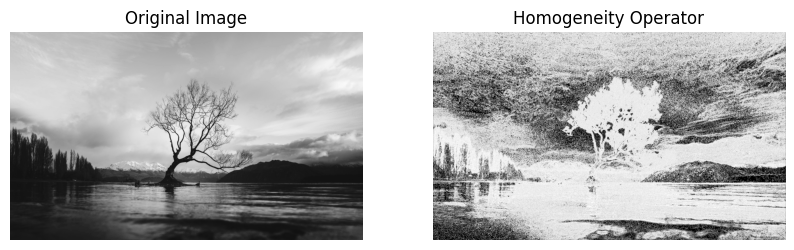

In [6]:
def homogeneity_operator(image, threshold=5):
    height, width = image.shape
    # Initializes an empty matrix (same size as the input) to store the edge-detected output.
    homogeneity_image = np.zeros_like(image)

    for i in range(1, height - 1):
        for j in range(1, width - 1):
            center_pixel = image[i , j]
            differences = [
                abs(center_pixel - image[i- 1 , j-1]),# Top-left neighbor
                abs(center_pixel - image[i-1, j]), # Top neighbor
                abs(center_pixel - image[i-1, j+1]), # Top-right neighbor
                abs(center_pixel - image[i, j-1]), # Left neighbor
                abs(center_pixel - image[i, j+1]), # Right neighbor
                abs(center_pixel - image[i+1, j-1]),# Bottom-left neighbor
                abs(center_pixel - image[i+1, j]),# Bottom neighbor
                abs(center_pixel - image[i+1, j+1]),# Bottom-right neighbor
            ]
            homogeneity_value = max(differences)
            homogeneity_image[i,j] = homogeneity_value
            homogeneity_image[i,j] = np.where(homogeneity_image[i,j]>= threshold, homogeneity_image[i,j], 0).astype(np.uint8)
        
    return homogeneity_image

image = cv2.imread('image1.jpg', cv2.IMREAD_GRAYSCALE)

edges = homogeneity_operator(image , threshold=10)
warnings.filterwarnings("ignore")



plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')


plt.subplot(1,2,2)
plt.title('Homogeneity Operator')
plt.imshow(edges, cmap='gray')
plt.axis('off')



(-0.5, 4974.5, 2939.5, -0.5)

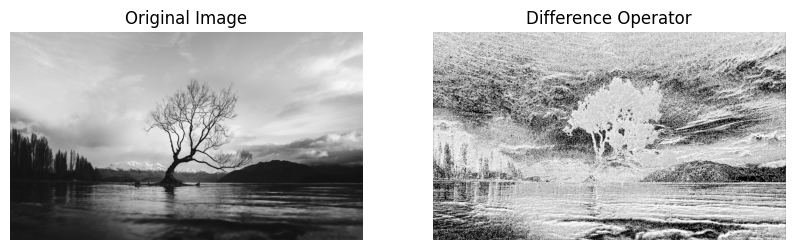

In [7]:
def difference_operator(image, threshold=10):
    height, width = image.shape
    difference_image = np.zeros_like(image)

    for i in range(1, height - 1):
        for j in range(1, width - 1):

            diff1 = abs(image[i-1, j-1] - image[i+1, j+1])# Main diagonal top left
            diff2 = abs(image[i-1, j+1] - image[i+1, j-1]) # Anti-diagonal
            diff3 = abs(image[i, j-1] - image[i, j+1]) # Horizontal axis
            diff4 = abs(image[i-1, j] - image[i+1, j]) # Vertical axis

            max_diff = max(diff1, diff2, diff3, diff4)
            difference_image[i,j] = max_diff

            difference_image[i,j] = np.where(difference_image[i,j] >= threshold, difference_image[i,j], 0).astype(np.uint8)
    
    return difference_image
    
image = cv2.imread('image1.jpg', cv2.IMREAD_GRAYSCALE)

edges = difference_operator(image , threshold=10)
warnings.filterwarnings("ignore")


plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')


plt.subplot(1,2,2)
plt.title('Difference Operator')
plt.imshow(edges, cmap='gray')
plt.axis('off')


(-0.5, 4974.5, 2939.5, -0.5)

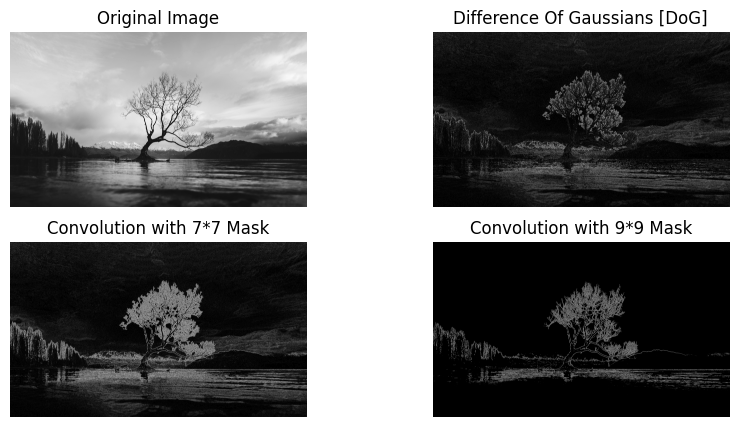

In [8]:
#useful for focusing on large objects while ignoring smaller details
#A narrow Gaussian (smaller σ) preserves more details 
#while a wide Gaussian (larger σ) smooths out finer details.


mask_7x7 = np.array([
    [0, 0, -1, -1, -1, 0, 0],
    [0, -2, -3, -3, -3, -2, 0],
    [-1, -3, 5, 5, 5, -3, -1],
    [-1, -3, 5, 16, 5, -3, -1],
    [-1, -3, 5, 5, 5, -3, -1],
    [0, -2, -3, -3, -3, -2, 0],
    [0, 0, -1, -1, -1, 0, 0]
], dtype=np.float32)



mask_9x9 = np.array([
    [0, 0, 0, -1, -1, -1, 0, 0, 0],
    [0, -2, -3, -3, -3, -3, -3, -2, 0],
    [0, -3, -2, -1, -1, -1, -2, -3, 0],
    [-1, -3, -1, 9, 9, 9, -1, -3, -1],
    [-1, -3, -1, 9, 19, 9, -1, -3, -1],
    [-1, -3, -1, 9, 9, 9, -1, -3, -1],
    [0, -3, -2, -1, -1, -1, -2, -3, 0],
    [0, -2, -3, -3, -3, -3, -3, -2, 0],
    [0, 0, 0, -1, -1, -1, 0, 0, 0]
    
    ], dtype=np.float32)

def difference_of_gaussians(image, mask1, mask2):
    blurred1 = cv2.filter2D(image, -1, mask1)
    blurred2 = cv2.filter2D(image, -1, mask2)

    dog = blurred1 - blurred2
    return dog, blurred1, blurred2

image = cv2.imread('image1.jpg', cv2.IMREAD_GRAYSCALE)

edges, blurred1, blurred2 = difference_of_gaussians(image, mask_7x7, mask_9x9)

plt.figure(figsize=(10,5))
plt.subplot(2,2,1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')


plt.subplot(2,2,2)
plt.title('Difference Of Gaussians [DoG]')
plt.imshow(edges, cmap='gray')
plt.axis('off')

plt.subplot(2,2,3)
plt.title('Convolution with 7*7 Mask')
plt.imshow(blurred1, cmap='gray')
plt.axis('off')

plt.subplot(2,2,4)
plt.title('Convolution with 9*9 Mask')
plt.imshow(blurred2, cmap='gray')
plt.axis('off')

(-0.5, 4974.5, 2939.5, -0.5)

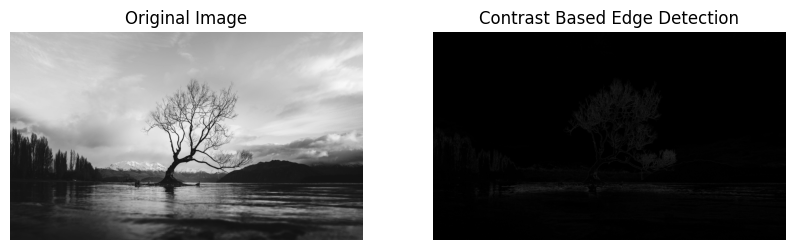

In [9]:
#Enhances edges by detecting contrasts between the center pixel and its neighbors.
def contrast_based_edge_detection(image):
    edge_mask = np.array([[-1, 0, -1],
                          [0, 4, 0],
                          [-1, 0, -1]])
    
    #averaging filter divides the sum of intensities
    smoothing_mask = np.ones((3, 3)) / 9
    
    edge_output = cv2.filter2D(image, -1, edge_mask)  #emphasizing regions of high intensity changes.
# the average intensity in a neighborhood.
    average_output = cv2.filter2D(image, -1, smoothing_mask)
    average_output = average_output.astype(float)  # might contain zero values in completely dark areas.
    average_output += 1e-10  #adding small constant to avoid division by 0

    contrast_edges = edge_output / average_output  

    return contrast_edges, edge_output, average_output

image = cv2.imread('image1.jpg', cv2.IMREAD_GRAYSCALE)

edges, edge_output, average_output = contrast_based_edge_detection(image) 

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title('Contrast Based Edge Detection')
plt.imshow(edges, cmap='gray')
plt.axis('off')

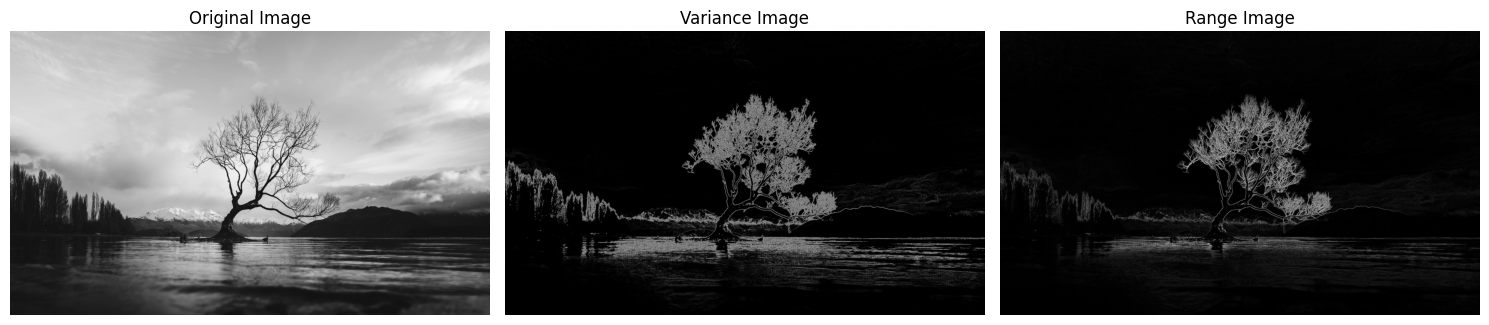

In [10]:
def variance_operator(image):
    output = np.zeros_like(image)
    height, width = image.shape
    for i in range(1, height - 1):
        for j in range(1, width - 1):
            neighborhood = image [i-1:i+2, j-1:j+2] #extracts a 3×3 neighborhood around the pixel located at (i, j)
            mean = np.mean(neighborhood)
            variance = np.sum((neighborhood - mean) **2) / 9
            output[i, j] = variance
    return output


def range_operator(image):
    output = np.zeros_like(image)
    height, width = image.shape
    for i in range(1, height - 1):
        for j in range(1, width - 1):
            neighborhood = image [i-1:i+2, j-1:j+2]
            range_value = np.max(neighborhood) - np.min(neighborhood)
            output[i, j] = range_value
    return output

image = cv2.imread('image1.jpg', cv2.IMREAD_GRAYSCALE)

variance_result = variance_operator(image)
range_result = range_operator(image)


plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.title('Variance Image')
plt.imshow(variance_result, cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.title('Range Image')
plt.imshow(range_result, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()
            

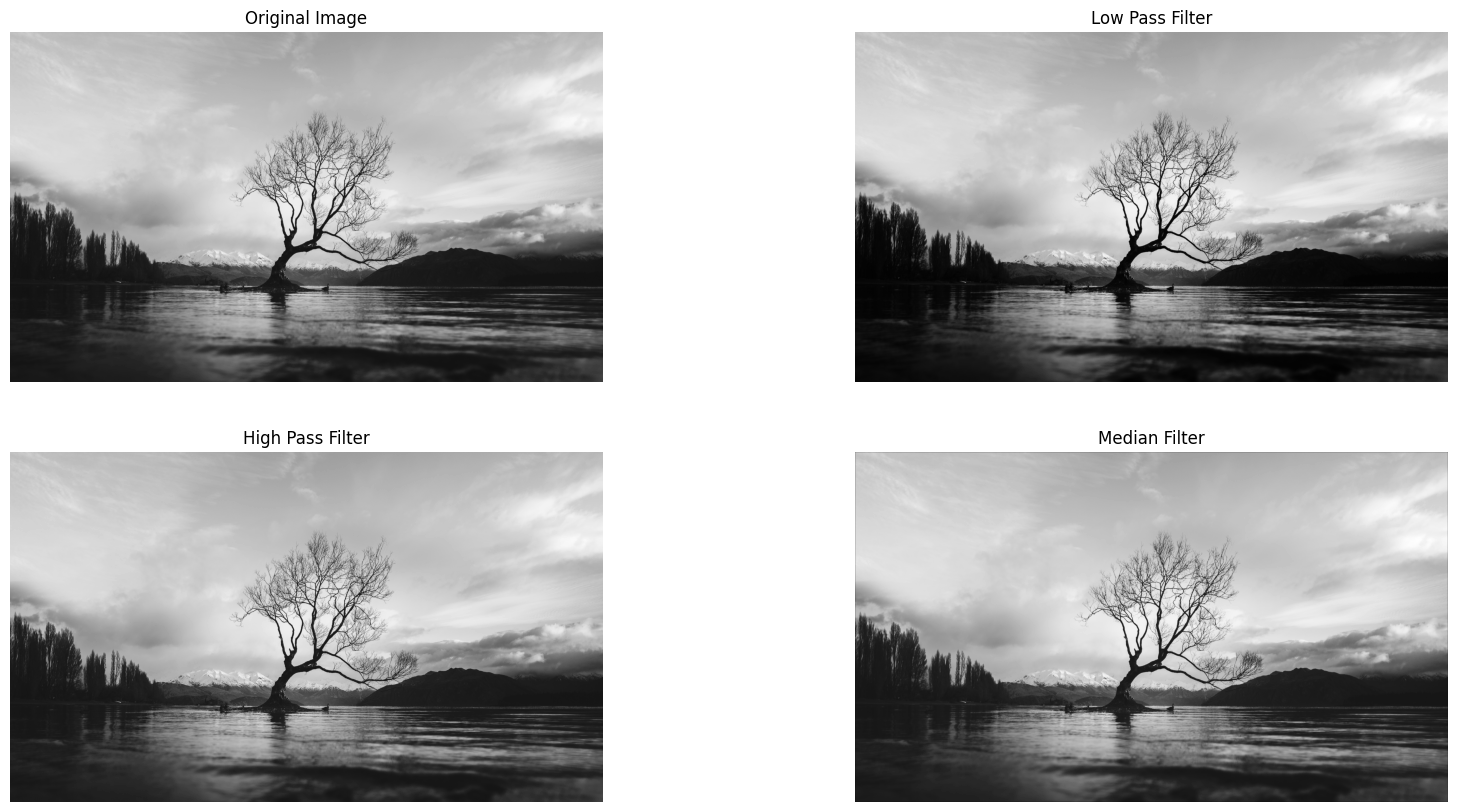

In [11]:
#enhance edges

mask_3x3_high_pass = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
], dtype=np.float32)

#smooth out noise

mask_3x3_low_pass = np.array([
    [0, 1/6, 0],
    [1/6, 2/6, 1/6],
    [0, 1/6, 0]
], dtype= np.float32)

def conv(image , mask1):
    result = cv2.filter2D(image, -1, mask1)
    return result

# replaces the center pixel with the median of the surrounding pixels. This is effective for 
#noise reduction while preserving edges

def median_filter(image):

    height, width = image.shape
    filtered_image = np.zeros_like(image)

    for i in range(1, height - 1):
        for j in range(1, width - 1):
            neighborhood = image[i-1:i+2, j-1:j+2]
            median_value = np.median(neighborhood)
            filtered_image[i , j] = median_value
    return filtered_image

image = cv2.imread('image1.jpg' , cv2.IMREAD_GRAYSCALE)


lowpass = conv(image , mask_3x3_low_pass)
highpass = conv(image , mask_3x3_high_pass)
median = median_filter(image)



# Display results
plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.title('Original Image')
plt.imshow(image, cmap= 'gray')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title('Low Pass Filter')
plt.imshow(lowpass, cmap= 'gray')
plt.axis('off')


plt.subplot(2, 2, 3)
plt.title('High Pass Filter')
plt.imshow(highpass, cmap= 'gray')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title('Median Filter')
plt.imshow(median, cmap= 'gray')
plt.axis('off')

plt.show()

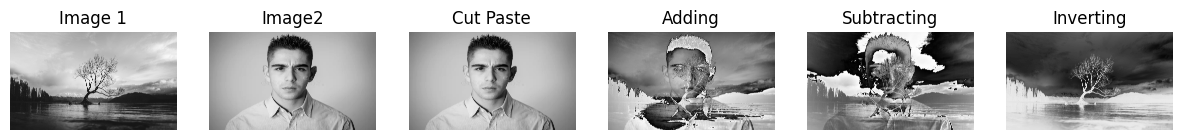

In [ ]:
def add(image1 , image2):
    height , width = image1.shape
    added_image = np.zeros((height , width), dtype=np.uint8)

    for i in range(height):
        for j in range(width):
            added_image[i , j] = image1[i , j] + image2[i , j]
            added_image[i , j] = max(0, min(added_image[i , j], 255))
    return added_image


def subtract(image1 , image2):
    height , width = image1.shape
    subtracted_image = np.zeros((height , width) , dtype= np.uint8)

    for i in range(height):
        for j in range(width):
            subtracted_image[i , j] = image1[i , j] - image2[i , j]
            subtracted_image[i , j] = max(0 , min(subtracted_image[i , j], 255))
    return subtracted_image


#inverts the pixel values, In gray shades: 0 becomes 255, 1 becomes 254, and so on

def invert(image1):
    height , width = image1.shape
    inverted_image = np.zeros((height,width), dtype= np.uint8)

    for i in range(height):
        for j in range(width):
            inverted_image[i , j] = 255 - image1[i , j]
    return inverted_image

#extract rectangular areas from one image and insert them into another

def cut_paste(image1 , image2 , position , size):
    x, y = position
    w, h = size 
    cut_image = image1[y:y+h , x:x+w]
    output_image = np.copy(image2)
    output_image[y:y+h , x:x+w] = cut_image
    return output_image
    

# image1 = np.array([
#     [0,100],
#     [50,150],
#     [200,255]
# ], dtype=np.float32)


# image2 = np.array([
#     [50,150],
#     [0,100],
#     [250,200]
# ], dtype=np.float32)

image1 =cv2.imread('image1.jpg' , cv2.IMREAD_GRAYSCALE)
image2 =cv2.imread('image2.jpg' , cv2.IMREAD_GRAYSCALE)

# Ensure both images have the same dimensions
if image1.shape != image2.shape:
    image2 = cv2.resize(image2, (image1.shape[1], image1.shape[0]))


adding = add(image1 , image2)
subtracting = subtract(image1, image2)
inverting = invert(image1)


cut_position = (0,0)
cut_size = (2,2)

cut_pasted = cut_paste(image1,image2 , cut_position , cut_size)



# Display results
plt.figure(figsize=(15, 5))
plt.subplot(1, 6, 1)
plt.title('Image 1')
plt.imshow(image1, cmap= 'gray', vmin = 0 , vmax = 255)
plt.axis('off')

plt.subplot(1, 6, 2)
plt.title('Image2')
plt.imshow(image2, cmap= 'gray',vmin = 0 , vmax = 255)
plt.axis('off')

plt.subplot(1, 6, 3)
plt.title('Cut Paste')
plt.imshow(cut_pasted, cmap= 'gray',vmin = 0 , vmax = 255)
plt.axis('off')


plt.subplot(1, 6, 4)
plt.title('Adding')
plt.imshow(adding, cmap= 'gray',vmin = 0 , vmax = 255)
plt.axis('off')

plt.subplot(1, 6, 5)
plt.title('Subtracting')
plt.imshow(subtracting, cmap= 'gray',vmin = 0 , vmax = 255)
plt.axis('off')


plt.subplot(1, 6, 6)
plt.title('Inverting')
plt.imshow(inverting, cmap= 'gray',vmin = 0 , vmax = 255)
plt.axis('off')


plt.show()

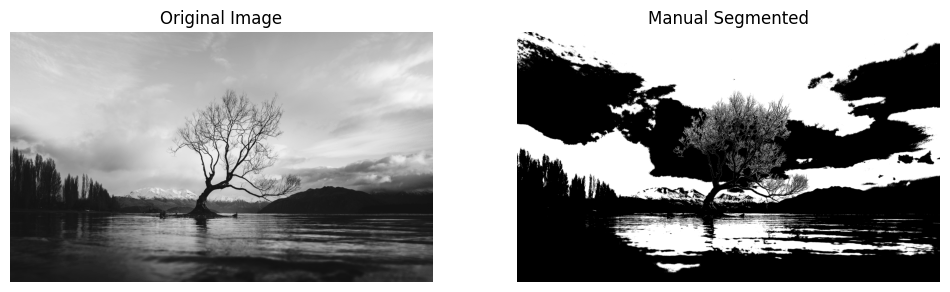

In [13]:
# manual technique this thresholds are the boundaries range for segmentation
def manual_segmentation(image , low_threshold , high_threshold , value = 255):
    segmented_image = np.zeros_like(image)
    segmented_image[(image >= low_threshold) & (image <= high_threshold)] = value
    return segmented_image


image = cv2.imread('image1.jpg' , cv2.IMREAD_GRAYSCALE)
manual_segmented = manual_segmentation(image , 100 , 200)

plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')


plt.subplot(1,2,2)
plt.title('Manual Segmented')
plt.imshow(manual_segmented, cmap='gray')
plt.axis('off')
plt.show()

Low Threshold: 115, High Threshold: 204


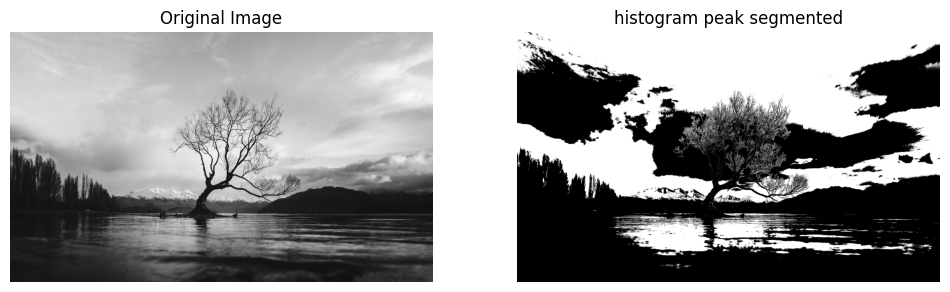

In [14]:
# histogram peak technique
def find_histogram_peaks(hist):
    # List to store indices of peaks
    peaks = []

    # Iterate through histogram values (ignoring the first and last indices)
    for i in range(1, len(hist) - 1):
        # Check if the current value is a peak
        if hist[i] > hist[i - 1] and hist[i] > hist[i + 1]:
            peaks.append(i)

    # Sort peaks by their values in descending order
    sorted_peaks = sorted(peaks, key=lambda x: hist[x], reverse=True)

    # Return the top 2 peaks
    return sorted_peaks[:2]


# Calculate thresholds based on found peaks
def calculate_thresholds(peaks_indices, hist):
    if len(peaks_indices) == 0:
        # No peaks found, use default thresholds
        print("No peaks found, using default thresholds.")
        return 0, 255
    elif len(peaks_indices) == 1:
        # Only one peak found, set lower threshold to that peak and upper to 255
        print("Only one peak found, using single threshold.")
        return peaks_indices[0], 255
    else:
        # Two peaks found, calculate thresholds based on them
        peak1 = peaks_indices[0]
        peak2 = peaks_indices[1]
        low_threshold = (peak1 + peak2) // 2
        high_threshold = peak2
        return low_threshold, high_threshold



# Apply histogram peak thresholding segmentation
def histogram_peak_threshold_segmentation(image):
    # Calculate the histogram of the image
    hist = np.zeros(256, dtype=np.int32)
    height, width = image.shape
    for i in range(height):
        for j in range(width):
            pixel_value = image[i, j]
            hist[pixel_value] += 1 
    
    # Find the peaks in the histogram
    peak_indices = find_histogram_peaks(hist)
    
    # Calculate low and high thresholds based on peaks
    low_threshold, high_threshold = calculate_thresholds(peak_indices, hist)
    print(f"Low Threshold: {low_threshold}, High Threshold: {high_threshold}")
    
    # Create a segmented image based on the thresholds
    segmented_image = np.zeros_like(image)
    segmented_image[(image >= low_threshold) & (image <= high_threshold)] = 255
    
    return segmented_image


image = cv2.imread('image1.jpg', cv2.IMREAD_GRAYSCALE) 

histogram_peak_segmented = histogram_peak_threshold_segmentation(image)

plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')


plt.subplot(1,2,2)
plt.title('histogram peak segmented')
plt.imshow(histogram_peak_segmented, cmap='gray')
plt.axis('off')
plt.show()

Low Threshold: 131, High Threshold: 204


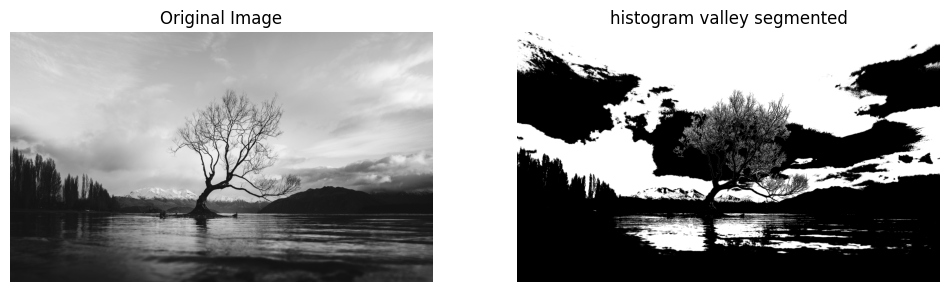

In [15]:
# Function to find the histogram peaks (local maxima)
def find_histogram_peaks(hist):
    peaks = []
    # Iterate through the histogram to find peaks
    for i in range(1, len(hist) - 1):
        if hist[i] > hist[i - 1] and hist[i] > hist[i + 1]:
            peaks.append(i)
    
    # Sort peaks based on their magnitude (higher peaks come first)
    sorted_peaks = sorted(peaks, key=lambda x: hist[x], reverse=True)
    
    # Return the top 2 peaks, or fewer if not available
    return sorted_peaks[:2]



# Function to find the valley between the peaks
def find_valley_point(peaks_indices, hist):
    valley_point = 0
    min_valley = float('inf')
    start, end = peaks_indices
    
    # Check only between the peaks
    for i in range(start, end + 1):
        if hist[i] < min_valley:
            min_valley = hist[i]
            valley_point = i
    return valley_point


# Calculate low and high thresholds based on valley point and peak
def valley_high_low(peaks_indices, valley_point):
    # If valley point is found, use it for low threshold
    if valley_point != 0:
        low_threshold = valley_point
        high_threshold = peaks_indices[1]
    else:
        # In case valley point is not found, fallback to default thresholds
        low_threshold = peaks_indices[0]
        high_threshold = peaks_indices[1]
    return low_threshold, high_threshold



# Apply histogram valley thresholding segmentation
def histogram_valley_threshold_segmentation(image):
    # Calculate the histogram of the image
    hist = np.zeros(256, dtype=np.int32)
    # Iterate through each pixel in the image
    height, width = image.shape
    for i in range(height):
        for j in range(width):
            pixel_value = image[i, j]
            hist[pixel_value] += 1
            
    # Find the peaks in the histogram
    peak_indices = find_histogram_peaks(hist)
    
    if len(peak_indices) < 2:
        print("Less than two peaks found, using default thresholds.")
        return image  # In case of fewer than two peaks, return original image
    
    # Find valley point between the peaks
    valley_point = find_valley_point(peak_indices, hist)
    
    # Calculate the low and high thresholds
    low_threshold, high_threshold = valley_high_low(peak_indices, valley_point)
    print(f"Low Threshold: {low_threshold}, High Threshold: {high_threshold}")
    
    # Create a segmented image based on the thresholds
    segmented_image = np.zeros_like(image)
    segmented_image[(image >= low_threshold) & (image <= high_threshold)] = 255
    
    return segmented_image

# Load the image
image = cv2.imread('image1.jpg', cv2.IMREAD_GRAYSCALE)



histogram_valley_segmented = histogram_valley_threshold_segmentation(image)


plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')


plt.subplot(1,2,2)
plt.title('histogram valley segmented')
plt.imshow(histogram_valley_segmented, cmap='gray')
plt.axis('off')
plt.show()

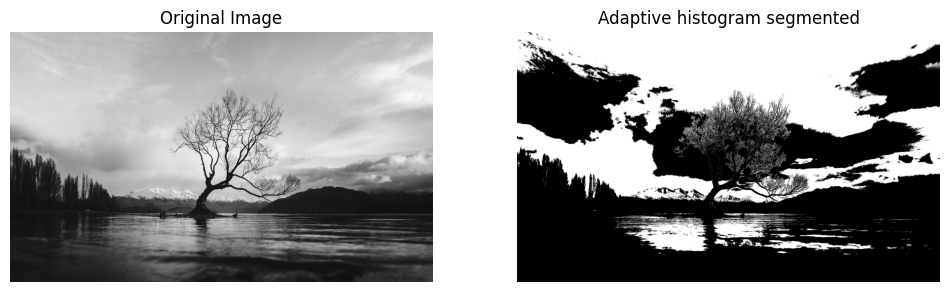

In [16]:
# Function to find the histogram peaks (local maxima)
def find_histogram_peaks(hist):
    peaks = []
    # Iterate through the histogram to find peaks
    for i in range(1, len(hist) - 1):
        if hist[i] > hist[i - 1] and hist[i] > hist[i + 1]:
            peaks.append(i)
    
    # Sort peaks based on their magnitude (higher peaks come first)
    sorted_peaks = sorted(peaks, key=lambda x: hist[x], reverse=True)
    
    # Return the top 2 peaks, or fewer if not available
    return sorted_peaks[:2] if len(sorted_peaks) >= 2 else []


# Function to find the valley between the peaks
def find_valley_point(peaks_indices, hist):
    if len(peaks_indices) < 2:
        return len(hist) // 2  # Return midpoint if not enough peaks are found
    
    # Simple approach: Find the valley (local minimum) between the two peaks
    valley = np.argmin(hist[peaks_indices[0]:peaks_indices[1]]) + peaks_indices[0]
    return valley

# Function to handle low/high thresholding based on peaks and valleys
def valley_high_low(peaks_indices, valley_point):
    # If there are less than two peaks, use default thresholds
    if len(peaks_indices) < 2:
        low_threshold = 0
        high_threshold = 255
    else:
        low_threshold = valley_point
        high_threshold = peaks_indices[1]  # The second peak (higher value)
    
    return low_threshold, high_threshold



# Function to calculate means for adaptive thresholding
def calculate_means(segmented_image, original_image):
    object_pixels = original_image[segmented_image == 255]  # Object is white (255)
    background_pixels = original_image[segmented_image == 0]  # Background is black (0)

    # Calculate the mean values for both object and background
    object_mean = object_pixels.mean() if object_pixels.size > 0 else 0
    background_mean = background_pixels.mean() if background_pixels.size > 0 else 0

    return background_mean, object_mean



# Adaptive histogram thresholding segmentation
def adaptive_histogram_threshold_segmentation(image, max_iterations=10, tolerance=1):
    
    # Create an array to hold the histogram values for 256 intensity levels
    hist = np.zeros(256, dtype=np.int32)

    # Iterate through each pixel in the image
    height, width = image.shape
    for i in range(height):
        for j in range(width):
            pixel_value = image[i, j]
            hist[pixel_value] += 1
    
    # Find the initial histogram peaks
    peaks_indices = find_histogram_peaks(hist)
    
    if len(peaks_indices) < 2:
        print("Less than two peaks found, using default thresholds.")
        return image  # In case of fewer than two peaks, return original image
    
    valley_point = find_valley_point(peaks_indices, hist)  # Assuming you have this function defined
    low_threshold, high_threshold = valley_high_low(peaks_indices, valley_point)
    
    prev_low_threshold, prev_high_threshold = low_threshold, high_threshold

    for iteration in range(max_iterations):
        # Apply initial thresholding based on current low and high thresholds
        segmented_image = np.zeros_like(image)
        segmented_image[(image >= low_threshold) & (image <= high_threshold)] = 255
        
        # Calculate the means of object and background
        background_mean, object_mean = calculate_means(segmented_image, image)
        
        # Update thresholds based on new means
        new_peaks_indices = [int(background_mean), int(object_mean)]
        new_low_threshold, new_high_threshold = valley_high_low(new_peaks_indices, valley_point)
        
        # If the thresholds converge (i.e., no significant change), break the loop
        if abs(new_low_threshold - prev_low_threshold) < tolerance and abs(new_high_threshold - prev_high_threshold) < tolerance:
            break
        
        prev_low_threshold, prev_high_threshold = new_low_threshold, new_high_threshold

    return segmented_image


# Load your image (ensure it's a grayscale image)
image = cv2.imread('image1.jpg', cv2.IMREAD_GRAYSCALE)

# Apply adaptive histogram threshold segmentation
adaptive_histogram_segmented = adaptive_histogram_threshold_segmentation(image)

    
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')


plt.subplot(1,2,2)
plt.title('Adaptive histogram segmented')
plt.imshow(adaptive_histogram_segmented, cmap='gray')
plt.axis('off')
plt.show()

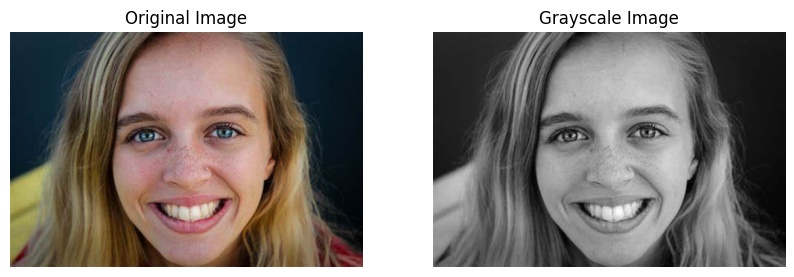

In [17]:
# Load the image
image = cv2.imread('image3.jpg')

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Display the original and grayscale images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert for displaying in matplotlib
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Grayscale Image')
plt.imshow(gray_image, cmap='gray')
plt.axis('off')

plt.show()

In [18]:
def calculate_threshold(image):
    avg_value = np.mean(image)
    threshold = avg_value / 2
    return threshold

In [23]:
# List of operations that require threshold
threshold_operations = [
    "Manual Segmentation", "Contrast-Based Edge Detection", 
    "Sobel Operator", "Prewitt Operator", "Kirsch Operator",
    "Halftoning", "Error Diffusion Halftoning", "Homogeneity",
    "Difference"
]

# Function to handle threshold-related operations
def apply_operation_with_threshold(image, operation_name, threshold):
    if operation_name == "Manual Segmentation":
        return manual_segmentation(image, threshold, 255)  # Example: manual segmentation
    elif operation_name == "Contrast-Based Edge Detection":
        edges, _, _ = contrast_based_edge_detection(image, threshold=threshold)
        return edges
    elif operation_name == "Sobel Operator":
        return detect_edges(image, method='sobel', threshold=threshold)
    elif operation_name == "Prewitt Operator":
        return detect_edges(image, method='prewitt', threshold=threshold)
    elif operation_name == "Kirsch Operator":
        return detect_edges(image, method='kirsch', threshold=threshold)
    # elif operation_name == "Halftoning":
    #     return halftone_threshold(image, threshold=threshold)
    # elif operation_name == "Error Diffusion Halftoning":
    #     return error_diffusion_halftoning(image, threshold=threshold)
    # elif operation_name == "Homogeneity":
    #     return homogeneity_operator(image, threshold=threshold)
    # elif operation_name == "Difference":
    #     return difference_operator(image, threshold=threshold)
    # Add other threshold-dependent operations as needed
    return None


# Function to handle threshold logic in the GUI
def handle_threshold_operation():
    global processed_image
    operation_name = operation_var.get()
    if original_image is None:
        tk.messagebox.showwarning("Warning", "Please load an image first.")
        return

    # Check if the operation requires a threshold
    threshold_required = operation_name in threshold_operations
    if threshold_required:
        # Clear previous widgets inside the threshold frame
        for widget in threshold_frame.winfo_children():
            widget.destroy()

        # Add threshold mode option (auto/manual)
        threshold_mode_var.set("Auto")  # Default is Auto
        auto_option = ttk.Radiobutton(threshold_frame, text="Auto", variable=threshold_mode_var, value="Auto")
        manual_option = ttk.Radiobutton(threshold_frame, text="Manual", variable=threshold_mode_var, value="Manual")
        auto_option.grid(row=0, column=0, padx=5, pady=5)
        manual_option.grid(row=0, column=1, padx=5, pady=5)

        # Add manual threshold input widget
        threshold_label = ttk.Label(threshold_frame, text="Threshold Value:")
        threshold_label.grid(row=1, column=0, padx=5, pady=5)

        threshold_entry = ttk.Entry(threshold_frame)
        threshold_entry.grid(row=1, column=1, padx=5, pady=5)

        # Add a button to apply the threshold
        def apply_threshold():
            threshold_mode = threshold_mode_var.get()
            if threshold_mode == "Auto":
                threshold = calculate_threshold(original_image)  # Assuming calculate_threshold is a function
            else:
                try:
                    threshold = float(threshold_entry.get())
                except ValueError:
                    tk.messagebox.showerror("Error", "Please enter a valid threshold value.")
                    return

            # Apply the operation with the threshold
            processed_image = apply_operation_with_threshold(original_image, operation_name, threshold)
            display_images_in_gui(original_image, processed_image, operation_name)

        apply_button = ttk.Button(threshold_frame, text="Apply Threshold", command=apply_threshold)
        apply_button.grid(row=2, column=0, columnspan=2, pady=10)




# Define functions for image processing operations

def load_image():
    global original_image, processed_image
    file_path = filedialog.askopenfilename(filetypes=[("Image Files", "*.jpg;*.jpeg;*.png;*.bmp;*.tiff")])
    if file_path:
        print(f"File selected: {file_path}")
        original_image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        if original_image is None:
            tk.messagebox.showerror("Error", "Failed to load the image.")
            return
        print(f"Original image shape: {original_image.shape}")
        processed_image = None
        display_images_in_gui(original_image, processed_image)



def resize_image(image, max_width=400, max_height=400):
    # Get the current dimensions of the image
    height, width = image.shape[:2]

    # Calculate the scale factor
    scale_factor = min(max_width / width, max_height / height)

    # Calculate the new dimensions
    new_width = int(width * scale_factor)
    new_height = int(height * scale_factor)

    # Resize the image using OpenCV
    resized_image = cv2.resize(image, (new_width, new_height))
    return resized_image

def display_images_in_gui(original, processed, operation_name=None):
    # Clear previous images
    for widget in image_frame.winfo_children():
        widget.destroy()

    # Resize original image if needed
    if original is not None:
        original_resized = resize_image(original)
        original_image_label = ttk.Label(image_frame, text="Original Image")
        original_image_label.pack()

        original_pil_image = Image.fromarray(original_resized)
        original_tk_image = ImageTk.PhotoImage(original_pil_image)
        original_canvas = tk.Canvas(image_frame, width=original_pil_image.width, height=original_pil_image.height)
        original_canvas.pack()
        original_canvas.create_image(0, 0, anchor=tk.NW, image=original_tk_image)
        original_canvas.image = original_tk_image  # Keep a reference to prevent garbage collection

    # Resize processed image if needed
    if processed is not None:
        processed_resized = resize_image(processed)
        processed_image_label = ttk.Label(image_frame, text=f"Processed Image: {operation_name or 'Result'}")
        processed_image_label.pack()

        # Convert processed image to a format Tkinter can handle
        processed_resized_rgb = cv2.cvtColor(processed_resized, cv2.COLOR_BGR2RGB)  # Convert to RGB for Tkinter
        processed_pil_image = Image.fromarray(processed_resized_rgb)
        processed_tk_image = ImageTk.PhotoImage(processed_pil_image)
        processed_canvas = tk.Canvas(image_frame, width=processed_pil_image.width, height=processed_pil_image.height)
        processed_canvas.pack()
        processed_canvas.create_image(0, 0, anchor=tk.NW, image=processed_tk_image)
        processed_canvas.image = processed_tk_image  # Keep a reference to prevent garbage collection


def apply_operation(operation):
    global processed_image
    if original_image is None:
        tk.messagebox.showwarning("Warning", "Please load an image first.")
        return

    # Convert the NumPy array to a PIL Image if needed
    pil_image = Image.fromarray(original_image)  # Convert from NumPy array
    
    # Perform the selected operation
    operation_name = None  # Initialize operation name
    threshold_required = operation in threshold_operations

    if threshold_required:
        # Trigger threshold-related options
        handle_threshold_operation()
        return  # Exit after handling threshold, as the user should apply threshold first
    

    if operation == "Contrast-Based Edge Detection":
        processed_image, edge_output, average_output = contrast_based_edge_detection(original_image)
        operation_name = "Contrast-Based Edge Detection"

    elif operation == "Variance":
        processed_image = variance_operator(original_image)
        operation_name = "Variance"

    elif operation == "Halftoning threshold":
        processed_image = halftone_threshold(original_image)
        operation_name = "Halftoning Threshold"

    elif operation == "Halftoning Error Diffusion":
        processed_image = error_diffusion_halftoning(pil_image)  # Use PIL Image
        operation_name = "Halftoning Error Diffusion"
        if isinstance(processed_image, Image.Image):
            processed_image = np.array(processed_image)



    elif operation == "Histogram Equalization":
        processed_image, histogram, sum_of_hist = histogram_equalization(original_image)
        operation_name = "Histogram Equalization"

    elif operation == "Homogeneity Operator":
        processed_image =homogeneity_operator(original_image)
        operation_name = "Homogeneity Operator"

    elif operation == "Difference Operator":
        processed_image =difference_operator(original_image)
        operation_name = "Difference Operator"

    elif operation == "Difference of Gaussians":
        # Perform DoG and get the three images
        edges, blurred1, blurred2 = difference_of_gaussians(original_image, mask_7x7, mask_9x9)

        # Plot the three images
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(blurred1, cmap='gray')
        axes[0].set_title('Blurred Image 1 (7x7 Gaussian)')
        axes[0].axis('off')

        axes[1].imshow(blurred2, cmap='gray')
        axes[1].set_title('Blurred Image 2 (9x9 Gaussian)')
        axes[1].axis('off')

        axes[2].imshow(edges, cmap='gray')
        axes[2].set_title('Difference of Gaussians (Edges)')
        axes[2].axis('off')

        plt.show()

        # For the processed image, you can choose to display the edges
        processed_image = edges
        operation_name = "Difference of Gaussians"

    elif operation == "Sobel Operator":
        processed_image =detect_edges(original_image,method='sobel',threshold=10)
        operation_name = "Sobel Operator"

    elif operation == "Prewitt Operator":
        processed_image =detect_edges(original_image,method='prewitt',threshold=10)
        operation_name = "Prewitt Operator"

    elif operation == "Kirsch Operator":
        processed_image =detect_edges(original_image,method='kirsch',threshold=10)
        operation_name = "Kirsch Operator"

    elif operation == "Range Operator":
        processed_image = range_operator(original_image)
        operation_name = "Range Operator"

    elif operation == "Low Pass Filter":
        processed_image = conv(original_image, mask_3x3_low_pass)
        operation_name = "Low Pass Filter"

    elif operation == "High Pass Filter":
        processed_image = conv(original_image, mask_3x3_high_pass)
        operation_name = "High Pass Filter"

    elif operation == "Median Filter":
        processed_image = median_filter(original_image)
        operation_name = "Median Filter"

    elif operation == "Add":
        processed_image = add(original_image, original_image)  # For simplicity, adding the image to itself
        operation_name = "Add Operation"

    elif operation == "Subtract":
        processed_image = subtract(original_image, original_image)  # For simplicity, subtracting itself
        operation_name = "Subtract Operation"

    elif operation == "Invert":
        processed_image = invert(original_image)
        operation_name = "Invert Operation"

    elif operation == "Manual Segmentation":
        processed_image = manual_segmentation(original_image, 100, 200)
        operation_name = "Manual Segmentation"

    elif operation == "Histogram Peak Segmentation":
        processed_image = histogram_peak_threshold_segmentation(original_image)
        operation_name = "Histogram Peak Segmentation"

    elif operation == "Histogram Valley Segmentation":
        processed_image = histogram_valley_threshold_segmentation(original_image)
        operation_name = "Histogram Valley Segmentation"

    elif operation == "Adaptive Histogram Segmentation":
        processed_image = adaptive_histogram_threshold_segmentation(original_image)
        operation_name = "Adaptive Histogram Segmentation"
    
    # Make sure processed_image is a valid uint8 array before displaying
    processed_image = np.uint8(processed_image)
    if len(processed_image.shape) == 2:  # If it's grayscale
        processed_image = cv2.cvtColor(processed_image, cv2.COLOR_GRAY2RGB)

    # Display the images
    display_images_in_gui(original_image, processed_image, operation_name)



# Initialize Tkinter GUI
root = tk.Tk()
root.title("Image Processing GUI")

# Variables
original_image = None
processed_image = None
threshold_mode_var = tk.StringVar()

# Add a frame for image display
image_frame = ttk.Frame(root, padding="10")
image_frame.grid(row=1, column=0, columnspan=3, sticky="NSEW")

# Add GUI Components
frame = ttk.Frame(root, padding="10")
frame.grid(row=0, column=0, sticky="EW")

# Buttons
load_button = ttk.Button(frame, text="Load Image", command=load_image)
load_button.grid(row=0, column=0, padx=5, pady=5)

# Dropdown for Operations
operation_var = tk.StringVar()
operations = [
    "Contrast-Based Edge Detection","Halftoning threshold","Halftoning Error Diffusion",
    "Variance", "Range Operator",
    "Low Pass Filter", "High Pass Filter", "Median Filter", "Add",
    "Subtract", "Invert", "Manual Segmentation",
    "Histogram Peak Segmentation", "Histogram Valley Segmentation",
    "Adaptive Histogram Segmentation","Histogram Equalization","Homogeneity Operator",
    "Difference Operator","Difference of Gaussians","Sobel Operator","Prewitt Operator",
    "Kirsch Operator"
]
operation_menu = ttk.OptionMenu(frame, operation_var, operations[0], *operations)
operation_menu.grid(row=0, column=1, padx=5, pady=5)

# Apply Button
apply_button = ttk.Button(frame, text="Apply Operation", command=lambda: apply_operation(operation_var.get()))
apply_button.grid(row=0, column=2, padx=5, pady=5)

# Threshold frame (to display threshold options)
threshold_frame = ttk.Frame(root, padding="10")
threshold_frame.grid(row=2, column=0, columnspan=3, sticky="NSEW")

# Start Tkinter main loop
root.mainloop()

File selected: D:/FCAIH/Year 4/Term 1/Image Processing/Sections/Project/image1.jpg
Original image shape: (2940, 4975)
File selected: D:/FCAIH/Year 4/Term 1/Image Processing/Sections/Project/image3.jpg
Original image shape: (316, 474)
File selected: D:/FCAIH/Year 4/Term 1/Image Processing/Sections/Project/image1.jpg
Original image shape: (2940, 4975)


In [20]:

# def calculate_threshold(image):
#     """
#     Calculate the threshold based on the average pixel value of the image.
#     """
#     # Calculate the mean pixel value of the image
#     mean_value = np.mean(image)
    
#     # The threshold will be the mean pixel value
#     threshold = mean_value
    
#     return threshold

# def apply_threshold(image, threshold):
#     """
#     Apply the calculated threshold to the image.
#     Pixels greater than the threshold will be white (255), and others will be black (0).
#     """
#     # Create a binary image by thresholding
#     _, binary_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)
    
#     return binary_image

# # Load image
# image = cv2.imread('image1.jpg', cv2.IMREAD_GRAYSCALE)

# # Calculate the threshold based on average pixel value
# threshold = calculate_threshold(image)

# # Apply the threshold to the image
# binary_image = apply_threshold(image, threshold)

# # Display the original and thresholded images
# plt.figure(figsize=(10, 5))

# plt.subplot(1, 2, 1)
# plt.title('Original Image')
# plt.imshow(image, cmap='gray')
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.title('Thresholded Image')
# plt.imshow(binary_image, cmap='gray')
# plt.axis('off')

# plt.show()

# print(f"Calculated Threshold: {threshold}")